# Day 6 - Voronoi diagram

<figure style="float: right; max-width: 25em; margin: 1em">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6d/Manhattan_Voronoi_Diagram.svg"
     alt="Manhattan Voronoi diagram illustration from Wikimedia"/>
<figcaption style="font-style: italic; font-size: smaller">

Manhattan Voronoi diagram  
Balu Ertl [<a href="https://creativecommons.org/licenses/by-sa/1.0">CC BY-SA 1.0</a>],<br/><a href="https://commons.wikimedia.org/wiki/File:Manhattan_Voronoi_Diagram.svg">from Wikimedia Commons</a>

</figcaption>
</figure>

Another computational geometry problem! This time we are asked to find the largest area in a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram).

The most efficient algorithm to produce the boundaries between the points ($O(n \log_2 n)$) is [Fortune's algorithm](https://en.wikipedia.org/wiki/Fortune%27s_algorithm), which (like [day 3](./Day%2003.ipynb)) is a [sweep line algorithm](https://en.wikipedia.org/wiki/Sweep_line_algorithm) to reduce the problem from 2 to 1 dimension. *But*, we don't need boundaries,  we need *area*. A simpler method is to just use a $O(kn)$ double loop to find which of $n$ elements is closest for each of the $k$ `(x, y)` points in the map.


There are three importand aspects to remember here:

1. we need to use [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry), not Euclidian distance, when doing our calculations.

2. If 2 or more coordinates are equidistant from a given `(x, y)` point, that point doesn't count as area for any of the coordinates. This means we can't just use `min()` here, and `sort()` would be needlessly precise. Instead, we only need to know the *top 2 smallest distances*; if these two are equidistance we know we can't give the area to anyone. To get the two N of anything, you want to use a [heap queue](https://docs.python.org/3/library/heapq.html#heapq.nsmallest), which gives us the result in $O(n)$ time rather than $O(n \log_2 n)$.

3. Per coordinate we need to track if their area stretches to infinity, so we can disqualify them from consideration when we ask for the maximum area. Any coordinate that can claim a `(x, y)` point on the boundaries (defined as the min and max x and y coordinates) can be expected to stretch to infinity.
</div>

In [1]:
from dataclasses import dataclass
from operator import attrgetter
from typing import Sequence
from itertools import product
from heapq import nsmallest


@dataclass
class Coordinate:
    __slots__ = ('x', 'y', 'area', 'is_infinite')

    x: int
    y: int
        
    def __post_init__(self):
        self.clear()
        
    @classmethod
    def from_line(cls, line: str) -> 'Coordinate':
        return cls(*map(int, line.split(',')))
    
    def distance(self, x: int, y: int) -> int:
        """Calculate the Manhattan distance from a given point"""
        return abs(self.x - x) + abs(self.y - y)

    def __setattr__(self, name, value):
        # block mutating x & y once set
        if name in 'xy' and getattr(self, name, None) is not None:
            raise AttributeError(f"{type(self).__name__}.{name} is immutable")
        super().__setattr__(name, value)

    def __delattr__(self, name):
        # block mutating x & y once set
        if name in 'xy' and getattr(self, name, None) is not None:
            raise AttributeError(f"{type(self).__name__}.{name} is immutable")
        super().__delattr__(name)
    
    def clear(self):
        """Reset the graph filling state"""
        self.area = 0
        self.is_infinite = False

    
def _fill_areas(coordinates: Sequence[Coordinate]) -> None:
    """Update the covered area value for all coordinates
    
    If a coordinate would cover an infinitely large area, is_infinite is set to True
    and area is left untouched.
    
    """
    getx, gety = attrgetter('x'), attrgetter('y') 
    xrange = range(min(map(getx, coordinates)), max(map(getx, coordinates)) + 1)
    yrange = range(min(map(gety, coordinates)), max(map(gety, coordinates)) + 1)
    xbounds, ybounds = {xrange[0], xrange[-1]}, {yrange[0], yrange[-1]}

    for x, y in product(xrange, yrange):
        candidate, next_ = nsmallest(2, coordinates, key=lambda c: c.distance(x, y))
        if candidate.distance(x, y) < next_.distance(x, y):
            candidate.area += 1
            if x in xbounds or y in ybounds:
                candidate.is_infinite = True

def find_max_area(coordinates: Sequence[Coordinate]) -> int:
    if not any(c.area or c.is_infinite for c in coordinates):
        _fill_areas(coordinates)
    return max(c.area for c in coordinates if not c.is_infinite)

In [2]:
testcoords = [Coordinate.from_line(l) for l in '''\
1, 1
1, 6
8, 3
3, 4
5, 5
8, 9'''.splitlines()]
assert find_max_area(testcoords) == 17
assert [c.is_infinite for c in testcoords] == [True, True, True, False, False, True]

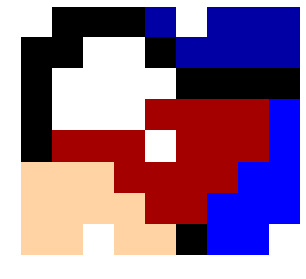

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import count

def visualise(coordinates: Sequence[Coordinate]) -> plt.Figure:
    getx, gety = attrgetter('x'), attrgetter('y') 
    xrange = range(min(map(getx, coordinates)), max(map(getx, coordinates)) + 1)
    yrange = range(min(map(gety, coordinates)), max(map(gety, coordinates)) + 1)
    
    # semi-random distribution of colour numbers
    colours = defaultdict(count(1).__next__)
    points = np.zeros(shape=(len(xrange), len(yrange)), dtype=np.uint8)
    
    for x, y in product(xrange, yrange):
        candidate, next_ = nsmallest(2, coordinates, key=lambda c: c.distance(x, y))
        if candidate.distance(x, y) < next_.distance(x, y):
            points[x - xrange.start, y - yrange.start] = colours[id(candidate)]
        if (candidate.x, candidate.y) == (x, y):
            # mark the centers
            points[x - xrange.start, y - yrange.start] = 255
    plt.axis('off')
    cmap = plt.get_cmap('flag')
    cmap.set_under('black')
    cmap.set_over('white')
    return plt.imshow(points, cmap=cmap, vmin=1, vmax=len(coordinates) + 1)

plt.rcParams['figure.figsize'] = [5, 5]
p = visualise(testcoords)

In [4]:
import aocd

data = aocd.get_data(day=6, year=2018)
coords = [Coordinate.from_line(l) for l in data.splitlines()]

In [5]:
print('Part 1:', find_max_area(coords))

Part 1: 4060


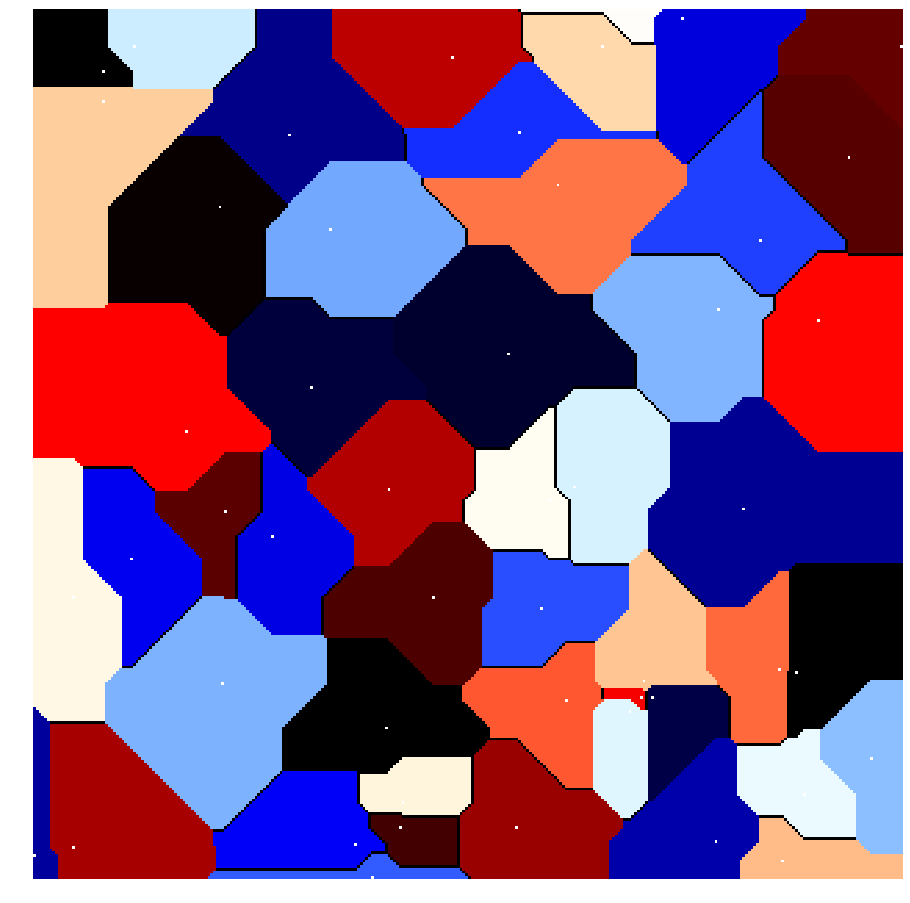

In [6]:
# All the coordinates mapped out:
plt.rcParams['figure.figsize'] = [16, 16]
p = visualise(coords)

## Part 2

We could look at scipy / numpy to do this work; summing the distances against a matrix is best left to specialised matrix tools. Scipy has just the right tool for us: [`spacial.cdist()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html), which lets us calculate the summed distances of two matrices!

So we need

an array for all the possible `(x, y)` positions for the coordinates

coord | x | y
------|---|---
  1   | 1 | 1
  2   | 1 | 6
  .   | . | .
  .   | . | .
  6   | 8 | 9    
    
an array of all possible `(x, y)` coordinates

 x | y
---|---
 0 | 0
 1 | 0
 2 | 0
 . | .
 . | .
 8 | 9

`cdist()` will give us a big matrix with all distances:

(x, y) | coord 1 | coord 2 | ... | coord 6
-------|---------|---------|-----|---------
(0, 0) |    0    |    5    | ... |   15
(0, 1) |    1    |    4    | ... |   14
(2, 0) |    2    |    3    | ... |   13
   .   |    .    |    .    | ... |    .
   .   |    .    |    .    | ... |    .
(8, 9) |   15    |   10    | ... |    0

which can trivially be summed over the first axis. Then we just have to count what number fall below the threshold.

In [7]:
from scipy.spatial import distance
from typing import Iterable

def area_within_threshold(coordinates: Iterable[Coordinate], treshold: int) -> int:
    destinations = np.array([[c.x, c.y] for c in coordinates])
    
    getx, gety = attrgetter('x'), attrgetter('y') 
    xrange = range(min(map(getx, coordinates)), max(map(getx, coordinates)) + 1)
    yrange = range(min(map(gety, coordinates)), max(map(gety, coordinates)) + 1)
    all_coordinates = np.array(list(product(xrange, yrange)))
    
    distances = distance.cdist(destinations, all_coordinates, metric='cityblock').sum(axis=0)

    return (distances < treshold).sum()

In [8]:
assert area_within_threshold(testcoords, 32) == 16

In [9]:
print('Part 2:', area_within_threshold(coords, 10000))

Part 2: 36136
